# Session 3: HDBSCAN Experimentation

**Objective**: Comprehensive parameter tuning for HDBSCAN (Hierarchical DBSCAN).

HDBSCAN advantages over DBSCAN:
- Does not require eps parameter selection
- Finds clusters of varying densities
- More robust noise handling
- Produces more stable clusterings

Key parameters to tune:
- **min_cluster_size**: Minimum points to form a cluster (most important)
- **min_samples**: Core point neighborhood size (defaults to min_cluster_size)
- **cluster_selection_epsilon**: Distance threshold
- **cluster_selection_method**: 'eom' (Excess of Mass) or 'leaf'

In [1]:
import sys
sys.path.insert(0, '..')
import os

# Set notebook directory as working directory
notebook_dir = '/Users/diegoaquino/IF4/DataMining/grandlyon-photo-clusters/notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import hdbscan
from sklearn.metrics import silhouette_score

from src.data_loader import load_cleaned_data
from src.clustering import (
    prepare_coordinates, 
    get_cluster_stats
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded!")

Working directory: /Users/diegoaquino/IF4/DataMining/grandlyon-photo-clusters/notebooks


Libraries loaded!


## 1. Load Data

In [2]:
# Load cleaned data
df = load_cleaned_data()
print(f"Loaded {len(df):,} photos")

# Prepare coordinates (unscaled for HDBSCAN - uses euclidean on lat/lon)
coords = prepare_coordinates(df, scale=False)

print(f"Coordinate range: lat ({coords[:, 0].min():.4f}, {coords[:, 0].max():.4f})")
print(f"                  lon ({coords[:, 1].min():.4f}, {coords[:, 1].max():.4f})")

Loaded 140,040 photos
Coordinate range: lat (45.6904, 45.8200)
                  lon (4.7700, 4.9200)


## 2. HDBSCAN Parameter Sweep: min_cluster_size

The **min_cluster_size** is the most important parameter in HDBSCAN.
It sets the minimum number of points to form a cluster.

Let's sweep across a range of values and measure:
- Number of clusters found
- Noise percentage
- Largest cluster size percentage
- Silhouette score (on a sample for efficiency)

In [3]:
# Define parameter values to test
min_cluster_sizes = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100]

# Pre-sample for fast silhouette calculation
np.random.seed(42)
sample_size = 10000
sample_idx = np.random.choice(len(coords), min(sample_size, len(coords)), replace=False)

def run_hdbscan_test(mcs, coords, sample_idx):
    """Run HDBSCAN and compute metrics."""
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=None,  # Defaults to min_cluster_size
        cluster_selection_epsilon=0.0,
        cluster_selection_method='eom',
        metric='euclidean'
    )
    labels = clusterer.fit_predict(coords)
    stats = get_cluster_stats(labels)
    
    # Silhouette on sample (only for clustered points)
    mask = labels[sample_idx] != -1
    if mask.sum() > 50 and stats['n_clusters'] > 1:
        sil = silhouette_score(coords[sample_idx][mask], labels[sample_idx][mask])
    else:
        sil = None
    
    return {
        'min_cluster_size': mcs,
        'n_clusters': stats['n_clusters'],
        'noise_pct': round(stats['noise_percentage'], 1),
        'largest_pct': round(stats['largest_cluster'] / len(labels) * 100, 1),
        'median_size': stats['median_cluster_size'],
        'silhouette': round(sil, 4) if sil else None
    }

print(f"Testing {len(min_cluster_sizes)} min_cluster_size values...")
results = []
for i, mcs in enumerate(min_cluster_sizes):
    print(f"  [{i+1}/{len(min_cluster_sizes)}] min_cluster_size={mcs}", end=" ")
    result = run_hdbscan_test(mcs, coords, sample_idx)
    results.append(result)
    print(f"→ clusters={result['n_clusters']}, noise={result['noise_pct']}%, sil={result['silhouette']}")

hdbscan_df = pd.DataFrame(results)
hdbscan_df

Testing 10 min_cluster_size values...
  [1/10] min_cluster_size=5 

→ clusters=6379, noise=24.4%, sil=0.6254
  [2/10] min_cluster_size=10 

→ clusters=3051, noise=33.4%, sil=0.7163
  [3/10] min_cluster_size=15 

→ clusters=1999, noise=38.7%, sil=0.7577
  [4/10] min_cluster_size=20 

→ clusters=1451, noise=41.5%, sil=0.7665
  [5/10] min_cluster_size=25 

→ clusters=1139, noise=43.3%, sil=0.7646
  [6/10] min_cluster_size=30 

→ clusters=924, noise=44.8%, sil=0.7674
  [7/10] min_cluster_size=40 

→ clusters=674, noise=46.6%, sil=0.7674
  [8/10] min_cluster_size=50 

→ clusters=517, noise=47.2%, sil=0.7512
  [9/10] min_cluster_size=75 

→ clusters=316, noise=48.3%, sil=0.7171
  [10/10] min_cluster_size=100 

→ clusters=237, noise=48.1%, sil=0.7162


,min_cluster_size,n_clusters,noise_pct,largest_pct,median_size,silhouette
0,5,6379,24.4,1.2,10,0.6254
1,10,3051,33.4,1.2,20,0.7163
2,15,1999,38.7,1.2,30,0.7577
3,20,1451,41.5,1.2,40,0.7665
4,25,1139,43.3,1.2,50,0.7646
5,30,924,44.8,1.2,59,0.7674
6,40,674,46.6,1.2,77,0.7674
7,50,517,47.2,1.2,100,0.7512
8,75,316,48.3,1.4,152,0.7171
9,100,237,48.1,1.7,208,0.7162


## 3. Visualize Parameter Sweep Results

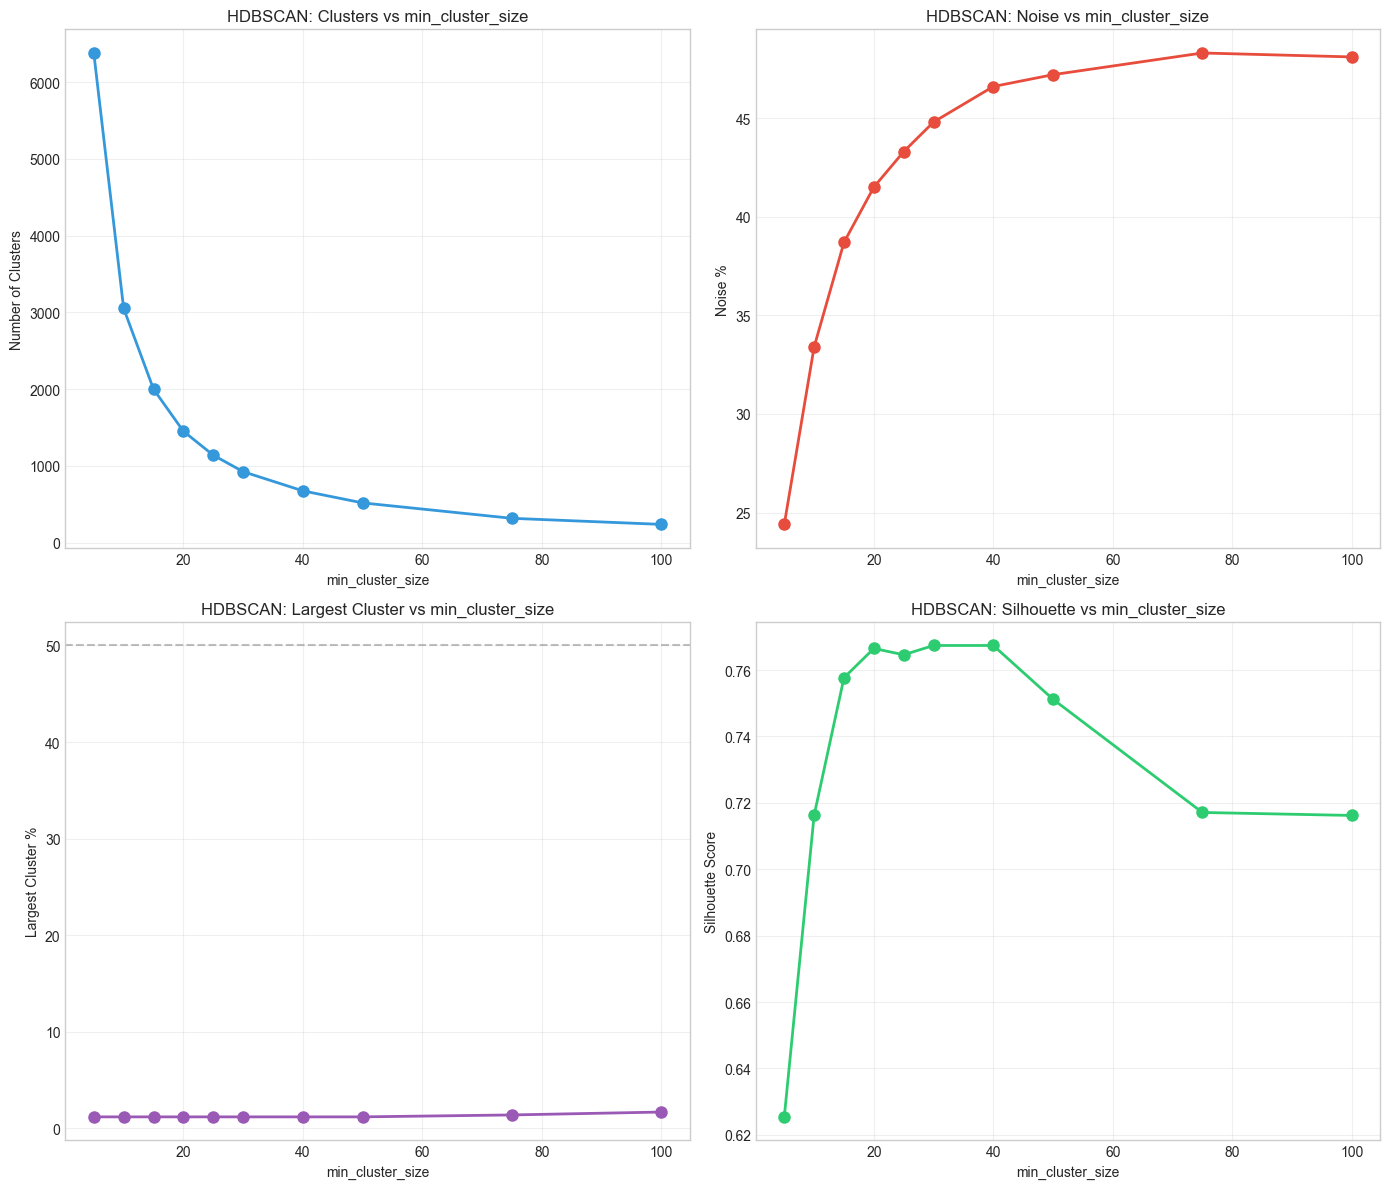


✅ Best HDBSCAN parameter (by silhouette):
   min_cluster_size = 30, silhouette = 0.7674
   Resulting in 924 clusters with 44.8% noise


In [4]:
# Visualize HDBSCAN parameter sweep
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Number of clusters
axes[0, 0].plot(hdbscan_df['min_cluster_size'], hdbscan_df['n_clusters'], 'o-', linewidth=2, markersize=8, color='#3498db')
axes[0, 0].set_xlabel('min_cluster_size')
axes[0, 0].set_ylabel('Number of Clusters')
axes[0, 0].set_title('HDBSCAN: Clusters vs min_cluster_size')
axes[0, 0].grid(True, alpha=0.3)

# Noise percentage
axes[0, 1].plot(hdbscan_df['min_cluster_size'], hdbscan_df['noise_pct'], 'o-', linewidth=2, markersize=8, color='#e74c3c')
axes[0, 1].set_xlabel('min_cluster_size')
axes[0, 1].set_ylabel('Noise %')
axes[0, 1].set_title('HDBSCAN: Noise vs min_cluster_size')
axes[0, 1].grid(True, alpha=0.3)

# Largest cluster percentage
axes[1, 0].plot(hdbscan_df['min_cluster_size'], hdbscan_df['largest_pct'], 'o-', linewidth=2, markersize=8, color='#9b59b6')
axes[1, 0].set_xlabel('min_cluster_size')
axes[1, 0].set_ylabel('Largest Cluster %')
axes[1, 0].set_title('HDBSCAN: Largest Cluster vs min_cluster_size')
axes[1, 0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
axes[1, 0].grid(True, alpha=0.3)

# Silhouette score
valid_sil = hdbscan_df.dropna(subset=['silhouette'])
axes[1, 1].plot(valid_sil['min_cluster_size'], valid_sil['silhouette'], 'o-', linewidth=2, markersize=8, color='#2ecc71')
axes[1, 1].set_xlabel('min_cluster_size')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('HDBSCAN: Silhouette vs min_cluster_size')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/hdbscan_parameter_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best min_cluster_size
best_hdbscan = hdbscan_df.dropna(subset=['silhouette']).loc[hdbscan_df['silhouette'].dropna().idxmax()]
print(f"\n✅ Best HDBSCAN parameter (by silhouette):")
print(f"   min_cluster_size = {int(best_hdbscan['min_cluster_size'])}, silhouette = {best_hdbscan['silhouette']:.4f}")
print(f"   Resulting in {int(best_hdbscan['n_clusters'])} clusters with {best_hdbscan['noise_pct']:.1f}% noise")

## 4. Secondary Parameter Sweep: min_samples

With the best min_cluster_size fixed, let's explore **min_samples**.
This controls how conservative the algorithm is in forming clusters.

In [5]:
# Use the best min_cluster_size from previous sweep
best_mcs = int(best_hdbscan['min_cluster_size'])
min_samples_values = [3, 5, 7, 10, 15, best_mcs, best_mcs + 10]

def run_hdbscan_ms_test(mcs, ms, coords, sample_idx):
    """Run HDBSCAN with specific min_samples."""
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_epsilon=0.0,
        cluster_selection_method='eom',
        metric='euclidean'
    )
    labels = clusterer.fit_predict(coords)
    stats = get_cluster_stats(labels)
    
    mask = labels[sample_idx] != -1
    if mask.sum() > 50 and stats['n_clusters'] > 1:
        sil = silhouette_score(coords[sample_idx][mask], labels[sample_idx][mask])
    else:
        sil = None
    
    return {
        'min_cluster_size': mcs,
        'min_samples': ms,
        'n_clusters': stats['n_clusters'],
        'noise_pct': round(stats['noise_percentage'], 1),
        'largest_pct': round(stats['largest_cluster'] / len(labels) * 100, 1),
        'silhouette': round(sil, 4) if sil else None
    }

print(f"Testing {len(min_samples_values)} min_samples values (with min_cluster_size={best_mcs})...")
ms_results = []
for i, ms in enumerate(min_samples_values):
    print(f"  [{i+1}/{len(min_samples_values)}] min_samples={ms}", end=" ")
    result = run_hdbscan_ms_test(best_mcs, ms, coords, sample_idx)
    ms_results.append(result)
    print(f"→ clusters={result['n_clusters']}, noise={result['noise_pct']}%, sil={result['silhouette']}")

ms_df = pd.DataFrame(ms_results)
ms_df

Testing 7 min_samples values (with min_cluster_size=30)...
  [1/7] min_samples=3 

→ clusters=1336, noise=28.4%, sil=0.6251
  [2/7] min_samples=5 

→ clusters=1257, noise=31.3%, sil=0.6482
  [3/7] min_samples=7 

→ clusters=1225, noise=33.2%, sil=0.6732
  [4/7] min_samples=10 

→ clusters=1151, noise=35.3%, sil=0.6905
  [5/7] min_samples=15 

→ clusters=1091, noise=38.8%, sil=0.7234
  [6/7] min_samples=30 

→ clusters=924, noise=44.8%, sil=0.7674
  [7/7] min_samples=40 

→ clusters=734, noise=46.3%, sil=0.7715


,min_cluster_size,min_samples,n_clusters,noise_pct,largest_pct,silhouette
0,30,3,1336,28.4,1.2,0.6251
1,30,5,1257,31.3,1.2,0.6482
2,30,7,1225,33.2,1.2,0.6732
3,30,10,1151,35.3,1.2,0.6905
4,30,15,1091,38.8,1.2,0.7234
5,30,30,924,44.8,1.2,0.7674
6,30,40,734,46.3,1.2,0.7715


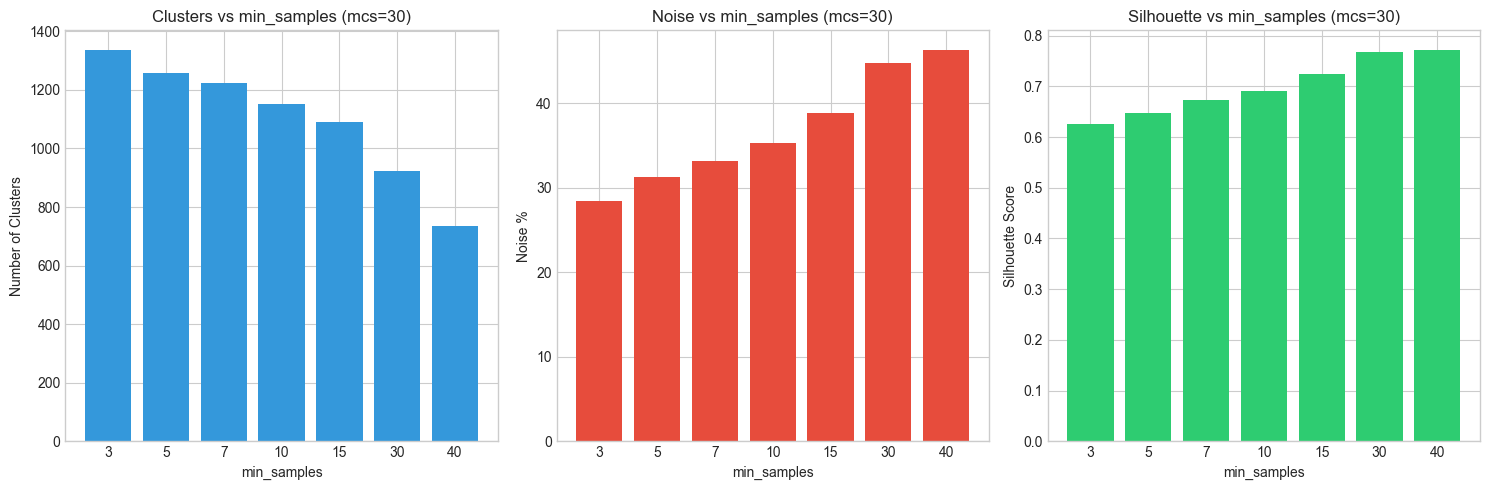

In [6]:
# Visualize min_samples sweep
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Number of clusters
axes[0].bar(range(len(ms_df)), ms_df['n_clusters'], color='#3498db')
axes[0].set_xticks(range(len(ms_df)))
axes[0].set_xticklabels([str(x) for x in ms_df['min_samples']])
axes[0].set_xlabel('min_samples')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title(f'Clusters vs min_samples (mcs={best_mcs})')

# Noise percentage
axes[1].bar(range(len(ms_df)), ms_df['noise_pct'], color='#e74c3c')
axes[1].set_xticks(range(len(ms_df)))
axes[1].set_xticklabels([str(x) for x in ms_df['min_samples']])
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('Noise %')
axes[1].set_title(f'Noise vs min_samples (mcs={best_mcs})')

# Silhouette
valid_ms = ms_df.dropna(subset=['silhouette'])
axes[2].bar(range(len(valid_ms)), valid_ms['silhouette'], color='#2ecc71')
axes[2].set_xticks(range(len(valid_ms)))
axes[2].set_xticklabels([str(x) for x in valid_ms['min_samples']])
axes[2].set_xlabel('min_samples')
axes[2].set_ylabel('Silhouette Score')
axes[2].set_title(f'Silhouette vs min_samples (mcs={best_mcs})')

plt.tight_layout()
plt.savefig('../reports/hdbscan_min_samples_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Complete Results Table

In [7]:
# Display full results table
print("\n" + "="*70)
print("HDBSCAN PARAMETER SWEEP RESULTS")
print("="*70)
print("\nmin_cluster_size sweep:")
print(hdbscan_df.to_string(index=False))
print("\nmin_samples sweep (with best min_cluster_size):")
print(ms_df.to_string(index=False))


HDBSCAN PARAMETER SWEEP RESULTS

min_cluster_size sweep:
 min_cluster_size  n_clusters  noise_pct  largest_pct  median_size  silhouette
                5        6379       24.4          1.2           10      0.6254
               10        3051       33.4          1.2           20      0.7163
               15        1999       38.7          1.2           30      0.7577
               20        1451       41.5          1.2           40      0.7665
               25        1139       43.3          1.2           50      0.7646
               30         924       44.8          1.2           59      0.7674
               40         674       46.6          1.2           77      0.7674
               50         517       47.2          1.2          100      0.7512
               75         316       48.3          1.4          152      0.7171
              100         237       48.1          1.7          208      0.7162

min_samples sweep (with best min_cluster_size):
 min_cluster_size  min_s

## 6. Save Results

In [8]:
# Save parameter sweep results
hdbscan_df.to_csv('../reports/hdbscan_mcs_tuning.csv', index=False)
ms_df.to_csv('../reports/hdbscan_ms_tuning.csv', index=False)

# Find overall best configuration
best_ms_row = ms_df.dropna(subset=['silhouette']).loc[ms_df['silhouette'].dropna().idxmax()]

# Save best parameters summary
best_params = {
    'timestamp': datetime.now().isoformat(),
    'hdbscan': {
        'min_cluster_size': int(best_ms_row['min_cluster_size']),
        'min_samples': int(best_ms_row['min_samples']),
        'silhouette': float(best_ms_row['silhouette']),
        'n_clusters': int(best_ms_row['n_clusters']),
        'noise_pct': float(best_ms_row['noise_pct'])
    }
}

import json
with open('../reports/best_hdbscan_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("✅ All results saved to reports/")
print(f"   - hdbscan_mcs_tuning.csv")
print(f"   - hdbscan_ms_tuning.csv")
print(f"   - hdbscan_parameter_sweep.png")
print(f"   - hdbscan_min_samples_sweep.png")
print(f"   - best_hdbscan_params.json")

✅ All results saved to reports/
   - hdbscan_mcs_tuning.csv
   - hdbscan_ms_tuning.csv
   - hdbscan_parameter_sweep.png
   - hdbscan_min_samples_sweep.png
   - best_hdbscan_params.json


## 7. Summary & Recommendations

In [9]:
print("=" * 70)
print("HDBSCAN EXPERIMENTATION SUMMARY")
print("=" * 70)
print()
print("Best parameters found:")
print()
print(f"  min_cluster_size: {int(best_ms_row['min_cluster_size'])}")
print(f"  min_samples:      {int(best_ms_row['min_samples'])}")
print(f"  Silhouette:       {best_ms_row['silhouette']:.4f}")
print(f"  Clusters:         {int(best_ms_row['n_clusters'])}")
print(f"  Noise:            {best_ms_row['noise_pct']:.1f}%")
print()
print("=" * 70)
print("Key observations:")
print("-" * 70)
print("1. HDBSCAN automatically detects clusters of varying density")
print("2. No need to specify 'eps' like in DBSCAN")
print("3. min_cluster_size is the most influential parameter")
print("4. Higher min_cluster_size = fewer, larger clusters + more noise")
print("5. min_samples controls sensitivity to noise points")
print()
print("Recommendation: Use these parameters in the main pipeline!")
print("=" * 70)

HDBSCAN EXPERIMENTATION SUMMARY

Best parameters found:

  min_cluster_size: 30
  min_samples:      40
  Silhouette:       0.7715
  Clusters:         734
  Noise:            46.3%

Key observations:
----------------------------------------------------------------------
1. HDBSCAN automatically detects clusters of varying density
2. No need to specify 'eps' like in DBSCAN
3. min_cluster_size is the most influential parameter
4. Higher min_cluster_size = fewer, larger clusters + more noise
5. min_samples controls sensitivity to noise points

Recommendation: Use these parameters in the main pipeline!
